In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from matplotlib.pyplot import imshow, imsave
import numpy as np
from torch.nn.utils import spectral_norm

from google.colab import drive
drive.mount('sample_data/drive')

Drive already mounted at sample_data/drive; to attempt to forcibly remount, call drive.mount("sample_data/drive", force_remount=True).


In [ ]:
!unzip "sample_data/drive/MyDrive/Colab Notebooks/Final_Lab/flowers6.zip" -d "sample_data/drive/MyDrive/Colab Notebooks/Final_Lab"

Archive:  sample_data/drive/MyDrive/Colab Notebooks/Final_Lab/flowers6.zip
replace sample_data/drive/MyDrive/Colab Notebooks/Final_Lab/flowers6/test/buttercup/image_1194.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
batch_size = 128
learning_rate = .0002
beta1 = .5
beta2 = .999
 
#epochs = 100
epochs = 9000

step = 0
n_critic = 1
n_noise = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_dir = "sample_data/drive/MyDrive/Colab Notebooks/Final_Lab/flowers6/train"
train_transforms = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor(), transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])])
train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, drop_last = True)

In [ ]:
# weight initialization G and D
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
#Convolution Discriminator

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv = nn.Sequential(
        #64 -> 32
        nn.Conv2d(3,512,3, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(.2),

        #32 -> 16
        nn.Conv2d(512,256,3,stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(.2),

        #16 -> 8
        nn.Conv2d(256,128,3,stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(.2),

        #AVG Pool 8/2 = 4, 4x4
        nn.AvgPool2d(2),
    )

    self.fc = nn.Sequential(
        #Reshape Input: 4x4x128 (128 since 2 pool) = 2048 avg 2 pool
        nn.Linear(2048,1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    y = self.conv(x)
    y = y.view(y.size(0),-1)
    y = self.fc(y)
    return y  

In [ ]:
#Convolutional Generator

class Generator(nn.Module):
  def __init__(self, input_size = 100):
    super(Generator, self).__init__()
    self.fc = nn.Sequential(
        nn.Linear(input_size, 8*8*512), #8*8*512
        nn.ReLU(),
    )

    self.conv = nn.Sequential(
        #8 -> 16
        spectral_norm(nn.ConvTranspose2d(512,256,4,stride = 2, padding = 1, bias = False)),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        #16 -> 32
        spectral_norm(nn.ConvTranspose2d(256,128,4,stride = 2, padding = 1, bias = False)),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        #32 -> 32
        spectral_norm(nn.ConvTranspose2d(128,64,3,stride = 1, padding = 1, bias = False)),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        #32 -> 32
        spectral_norm(nn.ConvTranspose2d(64,32,3,stride = 1, padding = 1, bias = False)),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        #32 -> 64
        spectral_norm(nn.ConvTranspose2d(32,3,4,stride = 2, padding = 1, bias = False)),
        nn.Tanh(),
    )

  def forward(self, x):
    x = x.view(x.size(0), -1)
    y = self.fc(x)
    y = y.view(y.size(0),512,8,8)
    y = self.conv(y)
    return y

In [ ]:
D = Discriminator().to(device)
G = Generator().to(device)


#randomly initialize weights so that mean=0, stdev=0.2.
G.apply(weights_init)

print(G)

#randomly initialize weights so that mean=0, stdev=0.2.
D.apply(weights_init)

print(D)

criterion = nn.BCELoss().to(device)
D_opt = torch.optim.Adam(D.parameters(), lr = learning_rate, betas = (beta1, beta2))
G_opt = torch.optim.Adam(G.parameters(), lr = learning_rate, betas = (beta1, beta2))

Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=32768, bias=True)
    (1): ReLU()
  )
  (conv): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4

In [ ]:
D_labels = torch.ones([batch_size, 1]).to(device)
D_fakes = torch.zeros([batch_size, 1]).to(device)
print(D_labels.shape)

torch.Size([128, 1])


In [ ]:
def get_sample_image(G, n_noise):
  z = torch.randn(100, n_noise).to(device)
  y_hat = G(z).view(100,64,64,3)

  result = y_hat.cpu().data.numpy()
  result = (result+1)/2.0

  img = np.zeros([640, 640,3])
  for j in range(10):
    img[j*64:(j+1)*64] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis = 1)
  return img

In [ ]:
path = "sample_data/drive/MyDrive/Colab Notebooks/Final_Lab/GAN_checkpoint_better_generator_V_9_Spectral_Layer_Aug_1"

In [ ]:
checkpoint = torch.load(path)
G.load_state_dict(checkpoint['G_state_dict'])
D.load_state_dict(checkpoint['D_state_dict'])

G.to(device)
D.to(device)

G_opt.load_state_dict(checkpoint['G_opt'])
D_opt.load_state_dict(checkpoint['D_opt'])
epoch = checkpoint['epoch']
D_loss = checkpoint['D_loss'] 
G_loss = checkpoint['G_loss'] 

In [ ]:
for epoch in range(epochs):
  for images, labels in train_loader:
    #Train Discriminator
    x = images.to(device)
    x_outputs = D(x)
    D_x_loss = criterion(x_outputs, D_labels)

    z = torch.randn(batch_size, n_noise).to(device)
    z_outputs = D(G(z))
    D_z_loss = criterion(z_outputs, D_fakes)
    D_loss = D_x_loss + D_z_loss

    D.zero_grad()
    D_loss.backward()
    D_opt.step()

    if step % n_critic == 0:
      #Training Generator
      z = torch.randn(batch_size, n_noise).to(device)
      z_outputs = D(G(z))
      G_loss = criterion(z_outputs, D_labels)

      D.zero_grad()
      G.zero_grad()
      G_loss.backward()
      G_opt.step()


    if step % 1000 == 0:
      G.eval()
      img = get_sample_image(G, n_noise)
      #print(img[0,0])
      #imsave('samples/{}_step.jpg'.format('DCGAN', str(step).zfill(3)), img, vmin = 0, vmax = 255)
      G.train()

    torch.save({'epoch': epoch+1,
              'G_state_dict': G.state_dict(),
              'D_state_dict': D.state_dict(),
              'G_opt': G_opt.state_dict(),
              'D_opt': D_opt.state_dict(),
              'D_loss': D_loss,
              'G_loss':G_loss}, path)

    step = step + 1

  print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss {}'.format(epoch,epochs,step,D_loss.item(), G_loss.item())) 

Streaming output truncated to the last 5000 lines.
Epoch: 4000/9000, Step: 12003, D Loss: 0.047139041125774384, G Loss 4.95211124420166
Epoch: 4001/9000, Step: 12006, D Loss: 0.038120612502098083, G Loss 4.630360126495361
Epoch: 4002/9000, Step: 12009, D Loss: 0.033403027802705765, G Loss 4.542823314666748
Epoch: 4003/9000, Step: 12012, D Loss: 0.039575912058353424, G Loss 4.863363742828369
Epoch: 4004/9000, Step: 12015, D Loss: 0.04347491264343262, G Loss 4.7254791259765625
Epoch: 4005/9000, Step: 12018, D Loss: 0.04312468320131302, G Loss 4.501323699951172
Epoch: 4006/9000, Step: 12021, D Loss: 0.04842504858970642, G Loss 5.805152416229248
Epoch: 4007/9000, Step: 12024, D Loss: 0.04362335056066513, G Loss 5.69490909576416
Epoch: 4008/9000, Step: 12027, D Loss: 0.041894618421792984, G Loss 5.43984842300415
Epoch: 4009/9000, Step: 12030, D Loss: 0.04323326796293259, G Loss 4.616034507751465
Epoch: 4010/9000, Step: 12033, D Loss: 0.047533825039863586, G Loss 4.696094989776611
Epoch: 401

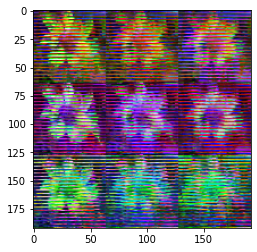

In [ ]:
import matplotlib.pyplot as plt 
G.eval()
test = get_sample_image(G,n_noise)

test = np.transpose(test.reshape((3,640,640)), (1,2,0))
plt.imshow(test[0:192,0:192,:])
#plt.imshow(test[0:672,0:672,:])